In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
from datetime import datetime
from datetime import timedelta
import matplotlib.cm as cm

In [2]:
def calc_NSE(Qo, Qm):
    QoAv  = np.mean(Qo)
    ErrUp = np.sum((Qo - Qm)**2)
    ErrDo = np.sum((Qo - QoAv)**2)
    return 1 - (ErrUp / ErrDo)
    
def calc_log_NSE(Qo, Qm):
    Qo[Qo == 0] = 1e-6
    QoAv  = np.mean(Qo)
    ErrUp = np.sum((np.log(Qo) - np.log(Qm))**2)
    ErrDo = np.sum((np.log(Qo) - np.log(QoAv))**2)
    return 1 - (ErrUp / ErrDo)

In [71]:
path = Path.cwd() 
figure_path = path / "Figures"

### DA best ensemble member

In [10]:
best_ds_files = list((path.parent / "nbs_42_also_store_Q_best" / 'Output').glob("*.nc"))

In [5]:
best_ds_lst = []
for file in best_ds_files:
    best_ds_lst.append(xr.open_dataset(file))

In [34]:
df_best = pd.DataFrame(columns=["NSE_mean_DA","log_NSE_mean_DA","NSE_best_DA","log_NSE_best_DA","path_DA"],)
for ds in best_ds_lst:
    uid = ds.attrs['HRU_id']
    df_best.loc[uid, 'NSE_mean_DA'] = calc_NSE(ds["Q_obs"].values, ds["Q"].sel(summary_stat="mean").values)
    df_best.loc[uid, 'log_NSE_mean_DA'] = calc_log_NSE(ds["Q_obs"].values, ds["Q"].sel(summary_stat="mean").values)
    df_best.loc[uid, 'NSE_best_DA'] = calc_NSE(ds["Q_obs"].values, ds["Q"].sel(summary_stat="best").values)
    df_best.loc[uid, 'log_NSE_best_DA'] = calc_log_NSE(ds["Q_obs"].values, ds["Q"].sel(summary_stat="best").values)
    df_best.loc[uid,'path_DA'] = file

In [35]:
df_best.head(3)

,NSE_mean_DA,log_NSE_mean_DA,NSE_best_DA,log_NSE_best_DA,path_DA
01078000,0.561461,0.487625,0.773989,0.730695,/media/davidhaasnoot/files/work/Studie TUD/Msc...
01013500,0.57813,-0.55511,0.861828,0.662818,/media/davidhaasnoot/files/work/Studie TUD/Msc...
01022500,0.521113,0.541622,0.655206,0.706836,/media/davidhaasnoot/files/work/Studie TUD/Msc...


### calibration

In [36]:
callibration_ds_files = list((path.parent / "nbs_41_callibration" / 'Output').glob("*.nc"))

In [37]:
cal_ds_lst = []
for file in callibration_ds_files:
    cal_ds_lst.append(xr.open_dataset(file))

In [38]:
cal_ds_lst[0]

<xarray.Dataset> Size: 475kB
Dimensions:         (EnsembleMember: 2, time: 1857)
Coordinates:
  * EnsembleMember  (EnsembleMember) int64 16B 42 129
  * time            (time) datetime64[ns] 15kB 1997-08-01 ... 2002-08-31
Data variables: (12/16)
    Imax            (EnsembleMember, time) float64 30kB ...
    Ce              (EnsembleMember, time) float64 30kB ...
    Sumax           (EnsembleMember, time) float64 30kB ...
    Beta            (EnsembleMember, time) float64 30kB ...
    Pmax            (EnsembleMember, time) float64 30kB ...
    Tlag            (EnsembleMember, time) float64 30kB ...
    ...              ...
    Su              (EnsembleMember, time) float64 30kB ...
    Sf              (EnsembleMember, time) float64 30kB ...
    Ss              (EnsembleMember, time) float64 30kB ...
    Sp              (EnsembleMember, time) float64 30kB ...
    Q               (EnsembleMember, time) float64 30kB ...
    Q_obs           (time) float64 15kB ...
Attributes:
    title:          HBV storage & parameter terms data over time for 500 part...
    history:        Storage term results from ewatercycle_HBV.model
    n_particles:    500
    HRU_id:         01078000
    NSE_max:        0.5898616531790566
    log_NSE_max:    0.7844750436173122
    i_NSE_max:      42
    i_log_NSE_max:  129

In [39]:
df_cal = pd.DataFrame(columns=["NSE_cal","log_NSE_cal","path_cal"],)
for ds in cal_ds_lst:
    uid = ds.attrs['HRU_id']
    df_cal.loc[uid, 'NSE_cal'] = ds.attrs['NSE_max']
    df_cal.loc[uid, 'log_NSE_cal'] = ds.attrs['log_NSE_max']
    df_cal.loc[uid,'path_cal'] = file

In [40]:
df_cal.head(3)

,NSE_cal,log_NSE_cal,path_cal
01078000,0.589862,0.784475,/media/davidhaasnoot/files/work/Studie TUD/Msc...
01139800,0.580599,0.588283,/media/davidhaasnoot/files/work/Studie TUD/Msc...
01013500,0.800059,0.771308,/media/davidhaasnoot/files/work/Studie TUD/Msc...


In [45]:
df = pd.concat([df_cal,df_best],axis=1)

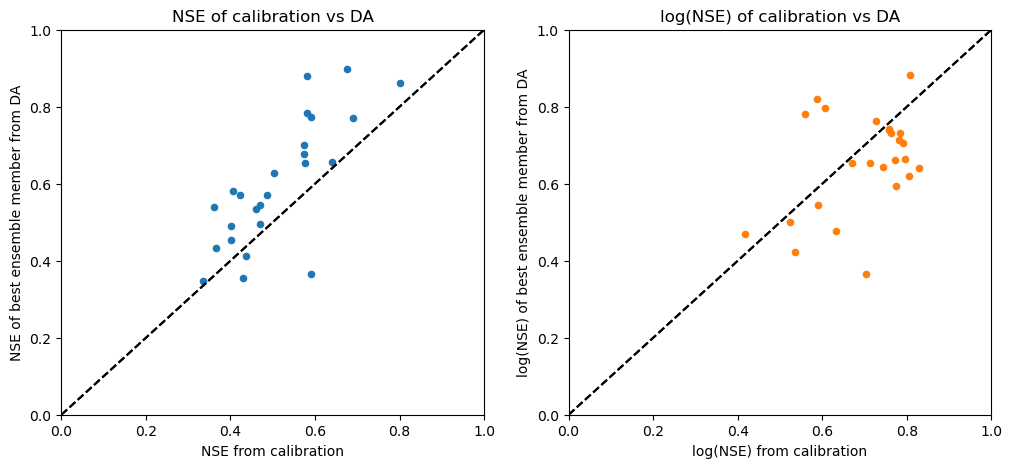

In [74]:
fig, axs = plt.subplots(1,2,figsize=(12,5))
ax = axs[0]
df.plot.scatter('NSE_cal','NSE_best_DA',ax=ax,color="C0")
ax.set_xlabel("NSE from calibration")
ax.set_ylabel("NSE of best ensemble member from DA")
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.plot([[0,0],[1,1]],color="k",ls="--")
ax.set_title('NSE of calibration vs DA')

ax = axs[1]
df.plot.scatter('log_NSE_cal','log_NSE_best_DA',ax=ax,color="C1")
ax.set_xlabel("log(NSE) from calibration")
ax.set_ylabel("log(NSE) of best ensemble member from DA")
ax.set_title('log(NSE) of calibration vs DA')
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.plot([[0,0],[1,1]],color="k",ls="--");

fig.savefig(figure_path / 'NSE_comparison.png',bbox_inches='tight',dpi=150)

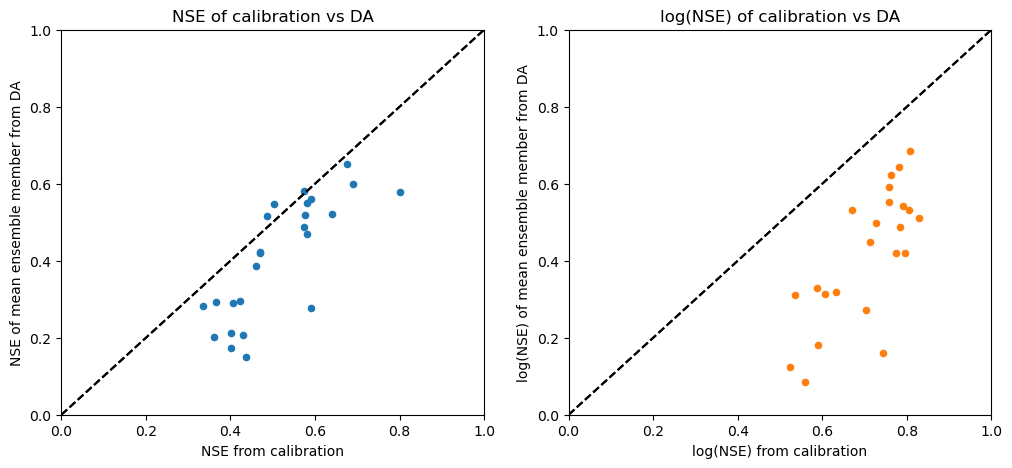

In [75]:
fig, axs = plt.subplots(1,2,figsize=(12,5))
ax = axs[0]
df.plot.scatter('NSE_cal','NSE_mean_DA',ax=ax,color="C0")
ax.set_xlabel("NSE from calibration")
ax.set_ylabel("NSE of mean ensemble member from DA")
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.plot([[0,0],[1,1]],color="k",ls="--")
ax.set_title('NSE of calibration vs DA')

ax = axs[1]
df.plot.scatter('log_NSE_cal','log_NSE_mean_DA',ax=ax,color="C1")
ax.set_xlabel("log(NSE) from calibration")
ax.set_ylabel("log(NSE) of mean ensemble member from DA")
ax.set_title('log(NSE) of calibration vs DA')
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.plot([[0,0],[1,1]],color="k",ls="--");

fig.savefig(figure_path / 'NSE_comparison.png',bbox_inches='tight',dpi=150)